In [7]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ahelis","key":"17c107cd717d10f32edfbb43bccbf2a6"}'}

In [8]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 62 Sep 15 13:49 kaggle.json


In [0]:
!pip install -q kaggle

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [11]:
!kaggle competitions download -c fake-news

 86% 81.0M/94.1M [00:00<00:00, 82.7MB/s]
100% 94.1M/94.1M [00:00<00:00, 102MB/s] 
 63% 15.0M/24.0M [00:00<00:00, 51.8MB/s]
100% 24.0M/24.0M [00:00<00:00, 79.9MB/s]


In [12]:
import os
import numpy as np
import pandas as pd
import nltk
import keras
import six
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import TimeDistributed,Conv1D,Dense,Embedding,Input,Dropout,LSTM,Bidirectional,AveragePooling1D,Flatten,concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import *
import h5py

Using TensorFlow backend.


In [13]:
os.listdir()

['.config', 'train.csv', 'kaggle.json', 'test.csv', 'sample_data']

# Read Data

In [14]:
train_df = pd.read_csv('train.csv')
train_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [15]:
test_df = pd.read_csv('test.csv')
test_df.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [0]:
articles = train_df['text'].values.tolist()

In [0]:
titles = train_df['title'].values.tolist()

In [0]:

labels = train_df['label'].values.tolist()

# Pre-process

In [19]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [0]:
# tokenizing words and removing punctuations and invalid values

article_w = []
labels_up = []
tokenizer = RegexpTokenizer(r'\w+')

for i,each_article in enumerate(articles):
    if(isinstance(each_article, six.string_types)):
        words = tokenizer.tokenize(each_article)
        article_w.append(words)
        labels_up.append(labels[i])

In [0]:
#removing stopwords

for i,each_article in enumerate(article_w):
    for word in each_article:
        if word in stop_words:
            each_article.remove(word)
    article_w[i] = each_article    

In [0]:
# POS tagger

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [0]:
# lemmatizing

lemmatizer = WordNetLemmatizer()
for i,each_article in enumerate(article_w):
    for j,word in enumerate(each_article):
        each_article[j] = lemmatizer.lemmatize(word, get_wordnet_pos(word))
    article_w[i] = each_article

# Embeddings Load

In [0]:
import gensim
import gensim.downloader as api
from gensim.models import KeyedVectors

In [0]:
# download the model and return as object

glove = api.load("glove-wiki-gigaword-100")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
#extract word to index dictionary

word2index = {token: token_index for token_index, token in enumerate(glove.index2word)}

In [0]:
#extract list of embeddings

wordEmbeddings = [glove[key] for key in word2index.keys()]

In [0]:
word2index["PADDING"] = len(word2index)
wordEmbeddings.append(np.zeros(len(wordEmbeddings[0])))
word2index["UNKNOWN"] = len(word2index)
wordEmbeddings.append(np.random.uniform(-0.25, 0.25, len(wordEmbeddings[0])))

In [0]:
wordEmbeddings = np.array(wordEmbeddings)
wordEmbeddings.shape

(400002, 100)

# Helper Functions

In [0]:
def embed(articles):
    embedded = []
    for article in articles:
        a_idx = []
        for word in article:
            if word in word2index.keys():
                a_idx.append(word2index[word])
            elif word.lower() in word2index.keys():
                a_idx.append(word2index[word.lower()])
            else:
                a_idx.append(word2index['UNKNOWN'])
        embedded.append(a_idx)
    return embedded

In [0]:
def find_max_len(articles):
    maxlen = 0
    tot = 0
    for article in articles:
        if len(article)>maxlen:
            maxlen = len(article)
        tot = tot + len(article)
    avg = tot/len(articles)
    return avg,maxlen

In [0]:
def padding(articles, maxm):
    padded = pad_sequences(articles, 600, padding='post', value=word2index['PADDING'])
    return padded

In [0]:
avg, maxm = find_max_len(article_w)
articles = embed(article_w)
articles = padding(articles, maxm)

In [0]:
avg

545.026780983575

In [0]:
x_train, x_test, y_train, y_test = train_test_split(articles, labels_up, test_size=0.2)
x_train.shape

(16608, 600)

# Model

In [0]:
words_input = Input(shape=(600,),dtype='int32',name='words_input')
words = Embedding(input_dim=wordEmbeddings.shape[0], output_dim=wordEmbeddings.shape[1],  weights=[wordEmbeddings], trainable=False)(words_input)
conv_1 = Conv1D(filters=100, kernel_size=10, strides=2, activation='relu')(words)
avgpool_1 = AveragePooling1D(pool_size=10, strides=10)(conv_1)
#conv_2 = Conv1D(filters=10, kernel_size=20, strides=2, activation='relu')(avgpool_1)
#avgpool_2 = AveragePooling1D(pool_size=10, strides=10)(conv_2)
#conv_3 = Conv1D(filters=10, kernel_size=20, strides=2)(avgpool_2)
#avgpool_3 = AveragePooling1D(pool_size=20, strides=2)(conv_3)
b_lstm = Bidirectional(LSTM(200, activation='tanh', return_sequences=False))(avgpool_1)
dense_1 = Dense(128, activation='relu')(b_lstm)
dropout = Dropout(0.4)(dense_1)
dense_2 = Dense(1, activation='sigmoid')(dropout)


sgd = keras.optimizers.RMSprop(lr=0.0001)
model = Model(inputs=words_input, outputs=dense_2)
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['acc'])
model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
words_input (InputLayer)     (None, 600)               0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 600, 100)          40000200  
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 296, 100)          100100    
_________________________________________________________________
average_pooling1d_14 (Averag (None, 29, 100)           0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 400)               481600    
_________________________________________________________________
dense_17 (Dense)             (None, 128)               51328     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0   

In [0]:
#es = EarlyStopping(monitor='loss', patience=10)
#mc = ModelCheckpoint('best_fnd.h5', monitor='val_acc', save_best_only=True)

In [0]:
history = model.fit(x=x_train, y=y_train, batch_size=64, epochs=20, validation_split=0.20) #, callbacks=[es])

Train on 13286 samples, validate on 3322 samples
Epoch 1/20
13286/13286 [==============================] - 31s 2ms/step - loss: 0.1509 - acc: 0.7799 - val_loss: 0.1303 - val_acc: 0.8137
Epoch 2/20
13286/13286 [==============================] - 28s 2ms/step - loss: 0.0935 - acc: 0.8732 - val_loss: 0.0883 - val_acc: 0.8814
Epoch 3/20
13286/13286 [==============================] - 27s 2ms/step - loss: 0.0660 - acc: 0.9150 - val_loss: 0.0641 - val_acc: 0.9214
Epoch 4/20
13286/13286 [==============================] - 27s 2ms/step - loss: 0.0527 - acc: 0.9299 - val_loss: 0.0654 - val_acc: 0.9157
Epoch 5/20
13286/13286 [==============================] - 27s 2ms/step - loss: 0.0392 - acc: 0.9499 - val_loss: 0.0785 - val_acc: 0.8961
Epoch 6/20
13286/13286 [==============================] - 27s 2ms/step - loss: 0.0295 - acc: 0.9629 - val_loss: 0.0632 - val_acc: 0.9175
Epoch 7/20
13286/13286 [==============================] - 27s 2ms/step - loss: 0.0213 - acc: 0.9745 - val_loss: 0.0650 - val_acc:

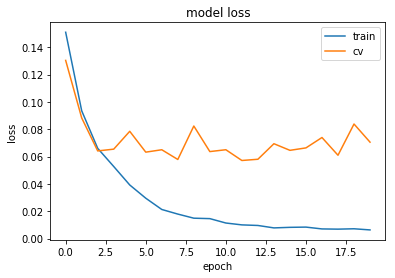

In [0]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='cv')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

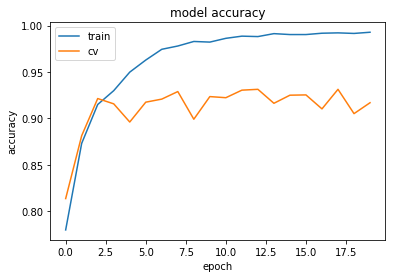

In [0]:
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='cv')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [0]:
pred = model.predict(x_test)
for i,p in enumerate(pred):
    if p>0.5:
        pred[i] = 1
    else:
        pred[i] = 0

In [0]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print(f1)

0.9252887108178175


In [0]:
#sgd = keras.optimizers.SGD(lr=0.1, momentum=0.006, decay=0.01, nesterov=True)
#sgd = keras.optimizers.SGD(lr=0.1, momentum=0.008, decay=0.02, nesterov=True)
#sgd = keras.optimizers.SGD(lr=0.5, momentum=0.008, decay=0.02, nesterov=True)--> 100 epochs --> 83.63 val_acc

# Save Models

In [0]:
model.save_weights('model_fnd_weights.h5')
model_json = model.to_json()
with open("model_fnd.json","w") as json_file:
     json_file.write(model_json)

In [0]:
from google.colab import files
files.download('model_fnd_weights.h5')
files.download('model_fnd.json')
#files.download('best_fnd.h5')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 41514, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil